In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
from Bio import Seq
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
import networkx as nx

In [3]:
sys.path.append("../..")
from utils import *

In [4]:
path = Path('F:/genome/mammals/')

In [5]:
classification_df = pd.read_csv(path/'enhancer_data.csv')

In [6]:
classification_df.head()

,Sequence,Enhancer,Organism,set
0,TGCGGGGTCTTGGCTCTCACGGTCGACTCTGCCTCTCGTGCCCGGG...,positive,Cat,train
1,TCCAGCCACTCCTGAGTCAACATGGCGGGCTTTCTTTGTTGGGCTC...,positive,Cat,train
2,GTGTGCTGGCCACCAGAGGGAGCCAGATCCCCCCTTTTCTCCTCCA...,positive,Cat,train
3,TGGGCGTTTTCACTGCGCGGTCTCTGCTCCTGCCCAACCGCAAGCG...,positive,Cat,train
4,GGCATTGGAGGGACCGAGAATAGGGAGGCCCTGGCCCAAAAAATCA...,positive,Cat,train


In [7]:
species = ['Human', 'Mouse', 'Dog', 'Opossum']
classification_df = classification_df[classification_df.Organism.isin(species)]

In [8]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [9]:
classification_df.Organism.unique()

array(['Dog', 'Human', 'Mouse', 'Opossum'], dtype=object)

In [10]:
train_df.shape, valid_df.shape, test_df.shape

((89598, 4), (11200, 4), (11200, 4))

In [11]:
train_df.Organism.value_counts()

Dog        22400
Human      22400
Mouse      22399
Opossum    22399
Name: Organism, dtype: int64

In [12]:
voc = np.load(path/'mammal_vocab.npy')
model_vocab = GenomicVocab(voc)

In [13]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [14]:
data = GenomicTextLMDataBunch.from_df(path, train_df, valid_df, bs=400, tokenizer=tok, 
                              chunksize=10000, text_cols='Sequence', label_cols='Enhancer', vocab=model_vocab)

In [15]:
len(data.train_dl)

794

In [18]:
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25, 
                          hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
drop_mult = 0.25

In [19]:
learn = get_model_LM(data, drop_mult, config)

In [20]:
learn.load('mammal1');

In [21]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(1025, 400, padding_idx=0)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(1025, 400, padding_idx=0)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=1025, bias=True)
    (output_dp): RNNDropout()
  )
)

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.74E-05


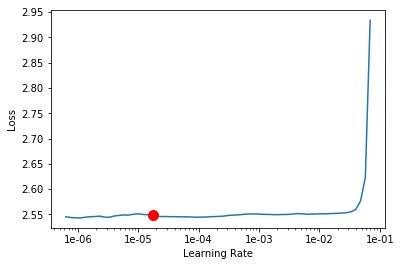

In [24]:
learn.recorder.plot(skip_end=13)

# Training


In [25]:
learn.fit_one_cycle(5, 3e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,2.512586,2.490902,0.198662
2,2.494360,2.474296,0.204392
3,2.468119,2.460560,0.209225
4,2.454153,2.452813,0.212168
5,2.430120,2.451890,0.212521


In [26]:
learn.save('encoder_LM_4o')
learn.save_encoder('encoder_LM_4o_enc')

In [27]:
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25, 
                          hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
drop_mult = 0.35

In [28]:
learn = get_model_LM(data, drop_mult, config)

In [29]:
learn.load('encoder_LM_4o');

In [26]:
learn.fit_one_cycle(2, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,2.511528,2.489891,0.200538
2,2.488613,2.478429,0.204513


In [27]:
learn.save('mammals_enhancers_finetune')
learn.save_encoder('mammals_enhancers_finetune_enc')

# Classification

In [5]:
classification_df = pd.read_csv(path/'enhancer_data.csv')

In [6]:
classification_df.head()

,Sequence,Enhancer,Organism,set
0,TGCGGGGTCTTGGCTCTCACGGTCGACTCTGCCTCTCGTGCCCGGG...,positive,Cat,train
1,TCCAGCCACTCCTGAGTCAACATGGCGGGCTTTCTTTGTTGGGCTC...,positive,Cat,train
2,GTGTGCTGGCCACCAGAGGGAGCCAGATCCCCCCTTTTCTCCTCCA...,positive,Cat,train
3,TGGGCGTTTTCACTGCGCGGTCTCTGCTCCTGCCCAACCGCAAGCG...,positive,Cat,train
4,GGCATTGGAGGGACCGAGAATAGGGAGGCCCTGGCCCAAAAAATCA...,positive,Cat,train


In [7]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [10]:
voc = np.load(path/'mammal_vocab.npy')
model_vocab = GenomicVocab(voc)

In [11]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, valid_df,
                                             tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Enhancer', bs=200)

In [15]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4, 
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.5

In [16]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [17]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(1025, 400, padding_idx=0)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(1025, 400, padding_idx=0)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.

In [18]:
learn.load_encoder('encoder_LM_4o_enc');
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.37E-03


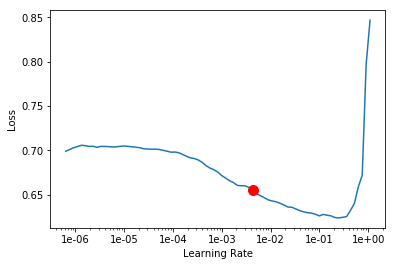

In [19]:
learn.lr_find()
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(3, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.557694,0.561245,0.711875
2,0.549602,0.541700,0.726696
3,0.543428,0.537031,0.731429


In [21]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.536279,0.531815,0.735357
2,0.536637,0.531634,0.734107
3,0.520823,0.524180,0.737679


In [22]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.520672,0.523924,0.737054
2,0.509259,0.519447,0.739018
3,0.503531,0.519219,0.739375


In [23]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.510741,0.518697,0.738661


KeyboardInterrupt: 